In [19]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [20]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [21]:
%cd /'gdrive'/'My Drive'

/gdrive/My Drive


#importing all the libraries

In [22]:
import cv2
import numpy as np
import torch
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision import models
import matplotlib.pyplot as plt

#preprocessing and visualizing the images

In [23]:
#Normalizing the images according to Resnet's input requirements
def preprocess_image(img: np.ndarray, mean=None, std=None) -> torch.Tensor:
    if std is None:
        std = [0.5, 0.5, 0.5]
    if mean is None:
        mean = [0.5, 0.5, 0.5]

    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])

    return preprocessing(img.copy()).unsqueeze(0)


def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)

#given localization map, this function superimposes the localization map onto the image
def show_cam_on_image(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

#class for keeping track of gradients and activations 

In [24]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = []
        self.activations = []

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations.append(output)

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        self.gradients = [grad_input[0]] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []        
        return self.model(x)

#CAM class for Grad-CAM

In [25]:
class CAM:
    def __init__(self, model, target_layer, use_cuda=False):
        self.model = model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.activations_and_grads = ActivationsAndGradients(self.model, target_layer)

    def forward(self, input_img):
        return self.model(input_img)
    
    def __call__(self, input_tensor, target_category=None):
        if self.cuda:
            input_tensor = input_tensor.cuda()

        output = self.activations_and_grads(input_tensor)
        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        #score of the predicted/ chosen class label
        one_hot = torch.sum(one_hot * output)
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        #fidning the activations and gradients
        activations = self.activations_and_grads.activations[-1].cpu().data.numpy()[0, :]
        grads = self.activations_and_grads.gradients[-1].cpu().data.numpy()[0, :]
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        #average gradients of the activation maps
        weights = np.mean(grads, axis=(1, 2))
        # finding the linear combination of the activation maps using above weights
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_tensor.shape[2:][::-1])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

#Main code code for the example

In [26]:
model = models.resnet50(pretrained=True)

# Choose the target layer you want to compute the visualization for.
# Usually this will be the last convolutional layer in the model.
# Some common choices can be:
# Resnet18 and 50: model.layer4[-1]
# VGG, densenet161: model.features[-1]
# mnasnet1_0: model.layers[-1]
# You can print the model to help chose the layer
target_layer = model.layer4[-1]

cam = CAM(model=model, 
          target_layer=target_layer,
          use_cuda=True)

rgb_img = cv2.imread("both.png", 1)[:, :, ::-1]
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], 
                                          std=[0.229, 0.224, 0.225])



#Visualization for the class prediction

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


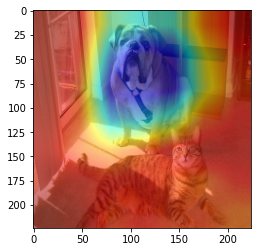

In [27]:
# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested category.
target_category = None #281
grayscale_cam = cam(input_tensor=input_tensor, 
                    target_category=target_category)

cam_image = show_cam_on_image(rgb_img, grayscale_cam)
plt.imshow(cam_image)

##Visualization for 'tabby, tabby cat' class

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


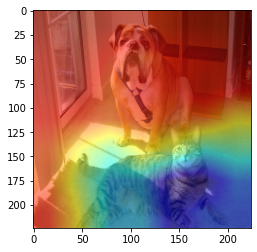

In [28]:
target_category = 281
grayscale_cam = cam(input_tensor=input_tensor, 
                    target_category=target_category)

cam_image = show_cam_on_image(rgb_img, grayscale_cam)
plt.imshow(cam_image)